In [1]:
import torch
import numpy as np

from lafomo.datasets import ToySpatialTranscriptomics
from lafomo.kernels import SpatioTemporalRBF
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter
from lafomo.variational.models import ReactionDiffusion
from matplotlib import pyplot as plt


In [2]:
import pandas as pd
data = pd.read_csv('../data/demToy1GPGene.csv')
data = pd.read_csv('../data/demToy1GPmRNA.csv')
display(data.head(5))

vals = data.values

def plot_output(ax, output, title=None):
    ax.set_title(title)
    ax.plot(output)
    ax.set_xlabel('distance')
    ax.set_ylabel('y')
def scatter_output(ax, output, title=None):
    ax.set_title(title)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=output)
    ax.set_xlabel('time')
    ax.set_ylabel('distance')
    ax.set_aspect('equal')

config = VariationalConfiguration(
    num_outputs=1, num_latents=1,
    initial_conditions=False
)

,t,x,U,Y
0,0.000,0.0,0.978006,0.0
1,0.025,0.0,1.009034,0.0
2,0.050,0.0,1.006165,0.0
3,0.075,0.0,0.967695,0.0
4,0.100,0.0,0.893023,0.0


In [3]:
tx = torch.tensor(data.values[:, 0:2]).permute(1, 0)
print(tx[:, 40::41].shape)

torch.Size([2, 41])


In [4]:
from torch.nn import Parameter
from lafomo.datasets import LFMDataset
from lafomo import LFM
from lafomo.variational.models import VariationalLFM


class PartialLFM(VariationalLFM):
    def __init__(self, config: VariationalConfiguration, kernel, t_inducing,
                 dataset: LFMDataset, dtype=torch.float64):
        super().__init__(config, kernel, t_inducing, dataset, dtype)
        if self.options.initial_conditions:
            raise Exception('Initial conditions are not implemented for PartialLFM.')

        T = 1.0            # final time
        self.time_steps = 40
        self.mesh_cells = 40
        self.fenics_module = ReactionDiffusion(self.time_steps/T, self.mesh_cells)
        self.sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
        self.decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
        self.diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)

    def forward(self, t, h, compute_var=False, return_samples=False):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Precompute variables
        self.Kmm = self.kernel(self.inducing_inputs)
        self.L = torch.cholesky(self.Kmm)
        q_cholS = torch.tril(self.q_cholS)
        self.S = torch.matmul(q_cholS, torch.transpose(q_cholS, 1, 2))

        # Integrate forward from the initial positions h0.

        ####
        outputs = list()
        y_prev = torch.zeros((1, self.mesh_cells + 1), requires_grad=False, dtype=torch.float64)
        t_index = 0
        tx = torch.tensor(data.values[:, 0:2]).permute(1, 0)

        for n in range(self.time_steps + 1):
            u = data[data['t'] == t[t_index]]['U'].values
            u = torch.tensor(u, requires_grad=False).unsqueeze(0)


            q_u = self.get_latents(tx[:, t_index::41])
            # Reparameterisation trick
            u = q_u.rsample([self.options.num_samples])  # (S, I, t)
            u = self.G(u)  # (S, num_outputs, t)
            # TODO use samples
            u = u[0]
            plt.plot(u[0].detach())
            # print(u.shape)
            y_prev = self.fenics_module(y_prev, u,
                                        self.sensitivity, self.decay, self.diffusion)

            # y_prev shape (N, 21)
            t_index += 1
            outputs.append(y_prev)
        outputs = torch.stack(outputs).permute(1, 0, 2)  # shape (batch, times, distance)

        return outputs
        ####
        # h_samples = odeint(self.odefunc, h0, t, )  # (T, S, num_outputs, 1)
        #
        # if return_samples:
        #     return h_samples
        #
        # h_out = torch.mean(h_samples, dim=1).transpose(0, 1)
        # h_std = torch.std(h_samples, dim=1).transpose(0, 1)
        #
        # if compute_var:
        #     return self.decode(h_out), h_std
        # return self.decode(h_out)

    def G(self, u):
        return u

In [5]:
from lafomo.variational.trainer import Trainer

class PDETrainer(Trainer):

    def single_epoch(self, *args):
        epoch_loss = 0
        epoch_ll = 0
        epoch_kl = 0
        output = None
        # for i, data in enumerate(self.data_loader):

        self.optimizer.zero_grad()
        # t, y = data
        # t = t.cuda() if is_cuda() else t
        # y = y.cuda() if is_cuda() else y
        # # Assume that the batch of t s are the same
        # t, y = t[0].view(-1), y
        # initial_value = self.initial_value(y)
        initial_value = None
        t = data['t'].values

        output = self.model(t, initial_value)

        y_target = torch.tensor(data['Y'].values).unsqueeze(0)
        print(y_target.shape)
        print(output.shape)
        output = output.transpose(1, 2).reshape(-1)
        print(output.shape)
        # loss = self.loss_fn(y_prev, y_target)
        # loss.backward()
        fig, axes = plt.subplots(ncols=2)
        scatter_output(axes[0], output.detach(), 'Prediction')
        scatter_output(axes[1], data.iloc[:, 3], 'Actual')

        # Calc loss and backprop gradients
        mult = 1
        if self.num_epochs <= 10:
            mult = self.num_epochs/10

        ll, kl = self.model.elbo(y_target, output, mult)
        total_loss = -ll #+ kl

        total_loss.backward()
        print('ses', self.model.sensitivity)
        print('grad', self.model.sensitivity.grad)

        self.optimizer.step()
        print("ses", self.model.sensitivity)

        epoch_loss += total_loss.item()
        epoch_ll += ll.item()
        epoch_kl += kl.item()

        # end for
        return output, epoch_loss, (-epoch_ll, epoch_kl)



t_inducing = torch.linspace(0, 1, 10, dtype=torch.float64).view(1, -1).repeat(2, 1)
print(t_inducing.shape)

kernel = SpatioTemporalRBF(config.num_latents, initial_lengthscale=0.3)

dataset = ToySpatialTranscriptomics()
model = PartialLFM(config, kernel, t_inducing, dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = PDETrainer(model, optimizer, dataset)

torch.Size([2, 10])
torch.Size([1, 2])


/Users/jacob/Documents/proj/reggae/lafomo/variational/models/model.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=options.learn_inducing)


torch.Size([1, 1681])
torch.Size([1, 41, 41])
torch.Size([1681])
ses Parameter containing:
tensor([[1.]], dtype=torch.float64, requires_grad=True)
grad tensor([[33629.5165]], dtype=torch.float64)
ses Parameter containing:
tensor([[0.9500]], dtype=torch.float64, requires_grad=True)
Epoch 1/1 - Loss: 17943.74 (17943.74  0.00  ) λ: 0.29 0.29


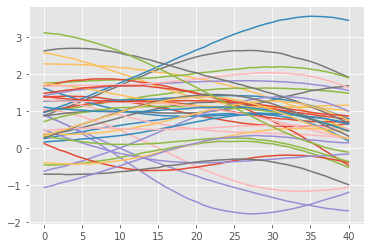

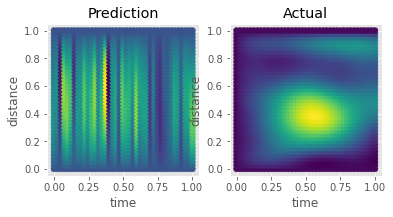

In [6]:
trainer.train(1)

In [ ]:
print(model.sensitivity, model.diffusion)

In [ ]:
fig, axes = plt.subplots(ncols=2)
scatter_output(axes[0], us.transpose(1, 2).reshape(-1), 'Prediction')
scatter_output(axes[1], data.iloc[:, 3], 'Actual')

plt.tight_layout()
fig, axes = plt.subplots(ncols=2)
plot_output(axes[0], us[0, 4, :], 'Prediction')
plot_output(axes[1], data[data['t'] == ts[4]].iloc[:, 3], 'Actual')

In [ ]:
plt.plot(data[data['t'] == ts[5]].iloc[:, 2])
plt.xlabel('distance')
plt.ylabel('u')

